In [1]:
suppressPackageStartupMessages(suppressWarnings({
    library(rhdf5)
    library(Matrix)
    library(CytoTRACE)
    library(ggplot2)
    library(viridis)
    library(LSD)
    library(dplyr)
    library(distances)
}))

In [2]:
## Custom HeatScatter implementation to function with ggplot

### heatscatterpoints ###


#' @export
#' @name heatscatterpoints
#' @aliases LSD.heatscatterpoints
#' @title A colored scatterplot based on a two-dimensional Kernel Density Estimation (add to an existing plot)
#' @description Visualize two dimensional data in a three dimensional fashion facilitating a color encoded Kernel Density Estimation (add to an existing plot).
#' @param x a numeric vector.
#' @param y a numeric vector.
#' @param pch plotting 'character'. This can either be a single character or an integer code for one of a set of graphics symbols. (see '?pch', to be passed to plot).
#' @param cexplot a numerical value giving the amount by which the points should be magnified relative to the default.
#' @param nrcol a non-negative integer specifying the number of colors to be used (defaults to 100, if not specified).
#' @param grid an integer specifying the size of the grid used for the KDE.
#' @param colpal a character vector containing R built-in color names or a name of a \code{LSD} colorpalette as a character string (see disco() or \code{\link{disco}}) (defaults to "heat", if not specified).
#' @param simulate logical: if \code{TRUE} (\code{FALSE} by default), a converted colorpalette is used to simulate dichromat vision according to \url{http://www.daltonize.org} (see \code{\link{daltonize}}).
#' @param daltonize logical: if \code{TRUE} (\code{FALSE} by default), a converted colorpalette is used to enhance dichromat vision according to \url{http://www.daltonize.org} (see \code{\link{daltonize}}).
#' @param cvd character string implying the type of color vision deficiency ("p" for protanope, "d" for deuteranope or "t" for tritanope). 
#' @param alpha alpha value: a two-digit integer between 01 and 99 for color opacity, i.e. appearance of partial or full transparency (usage omitted by default).
#' @param rev logical: if \code{TRUE} (\code{FALSE} by default), a reversed colorpalette is used.
#' @param xlim x limits, standard graphics parameter.
#' @param ylim y limits, standard graphics parameter.
#' @param only a character string which contains 'x' if the density should only be computed for the x axis, 'y' for the y axis (defaults to 'none' for the two-dimensional case).
#' @param add.contour logical: if \code{TRUE} (\code{FALSE} by default), the contour lines are added to the plot.
#' @param nlevels an integer giving the number of levels of the contour lines.
#' @param color.contour R build-in color for the contour lines.
#' @param greyscale logical: if \code{TRUE} (\code{FALSE} by default), the used colorpalette is converted to greyscales.
#' @param log a character string which contains "x" if the x axis is to be logarithmic, "y" if the y axis is to be logarithmic and "xy" or "yx" if both axes are to be logarithmic.
#' @param ggplot a logical: if \code{TRUE} uses the ggplot2 library to create plots. Defaults to \code{FALSE}.
#' @param xlab x labels, standard graphics parameter.
#' @param ylab y labels, standard graphics parameter.
#' @param ... additional parameters to be passed to points and plot.
#' @author Bjoern Schwalb
#' @seealso \code{\link{comparisonplot}}, \code{\link{demotour}}, \code{\link{disco}}, \code{\link{colorpalette}}
#' @note Two-Dimensional Kernel Density Estimation adapted and modified from Venables and Ripley's MASS package (see reference).
#' @references Venables, W. N. and Ripley, B. D. (2002) \emph{Modern Applied Statistics with S.} Fourth edition. Springer.
#' @examples points = 10^4
#' x = c(rnorm(points/2),rnorm(points/2)+4)
#' y = x + rnorm(points,sd=0.8)
#' x = sign(x)*abs(x)^1.3
#' 
#' plot.new()
#' plot.window(xlim = c(-5,15),ylim = c(-4,8))
#' heatscatterpoints(x,y,add.contour=TRUE,color.contour="green",greyscale=TRUE)
#' axis(1)
#' axis(2)
#' box()
#' @keywords scatterplot heatcolors


heatscatterpoints = function(x,y,pch = 19,cexplot = 0.5,nrcol = 30,grid = 100,colpal = "heat",simulate = FALSE,daltonize = FALSE,cvd = "p",alpha = NULL,rev = FALSE,xlim = NULL,ylim = NULL,only = "none",add.contour = FALSE,nlevels = 10,color.contour = "black",greyscale = FALSE,log = "",ggplot = FALSE, xlab=NULL, ylab=NULL,...)
{
	# soundcheck #
	
	if (!is.vector(x) | !is.vector(y)) stop("First two argument must be numeric vectors!")
	if (length(x) != length(y)) stop("Data vectors must be of the same length!")
	sound = which((!(is.na(x)|is.nan(x)|(x==Inf)|(x==-Inf))) & (!(is.na(y)|is.nan(y)|(y==Inf)|(y==-Inf))))
	if (length(sound)==0) stop("There are no valid point pairs to plot!")
	x = x[sound]
	y = y[sound]
	if (!is.null(xlim)){cut = x >= xlim[1] & x <= xlim[2]
	x = x[cut]
	y = y[cut]
	}
	if (!is.null(ylim)){cut = y >= ylim[1] & y <= ylim[2]
	y = y[cut]
	x = x[cut]
	}
	
	# color handling #
	colpal = colorpalette(colpal,nrcol,simulate = simulate,daltonize = daltonize,cvd = cvd,alpha = alpha,rev = rev)
	if (greyscale){colpal = convertgrey(colpal)}
	
	# binninmg function #
	
	todiscrete = function(t,tmin,tmax,bins){
		erg = round((t-tmin)/(tmax-tmin)*bins+0.5)
		erg = pmin(pmax(erg,1),bins)
		return(erg)
	}
	
	# kde2d.adj function: adapted and modified from Venables and Ripley's MASS package (distributed under the GPL-2 | GPL-3 license, https://cran.r-project.org/web/packages/MASS/index.html) #
	
	kde2d.adj = function(x,y,h,n = 25,lims = c(range(x),range(y)),only = "none"){
		nx = length(x)
		gx = seq.int(lims[1],lims[2],length.out = n)
		gy = seq.int(lims[3],lims[4],length.out = n)
		bandwidth.nrd.adj = function(x) 
		{
			r = quantile(x,c(0.25,0.75))
			h = (r[2] - r[1])/1.34
			return(4*1.06*min(sqrt(var(x)),h)*length(x)^(-1/5))
		}
		if (missing(h)) {
			bx = bandwidth.nrd.adj(x)
			by = bandwidth.nrd.adj(y)
			if (all(c(bx,by) == 0)){h = rep(0.01,2)} else if (any(c(bx,by) == 0)){h = rep(max(bx,by),2)} else {h = c(bx,by)}
		} else h = rep(h,length.out = 2)
		h = h/4
		ax = outer(gx,x,"-")/h[1]
		ay = outer(gy,y,"-")/h[2]
		norm.ax = dnorm(ax)
		norm.ay = dnorm(ay)
		if (only == "x"){norm.ay = rep(1,length(ay))}
		if (only == "y"){norm.ax = rep(1,length(ax))}
		z = tcrossprod(matrix(norm.ax,,nx),matrix(norm.ay,,nx))/(nx*h[1]*h[2])
		list(x = gx,y = gy,z = z)
	}
	
	# handle 'log' option #
	
	if (log == ""){
		xlog = x
		ylog = y
	} else if (log == "x"){
		xlog = log(x,10)
		ylog = y
	} else if (log == "y"){
		xlog = x
		ylog = log(y,10)
	} else if (log %in% c("xy","yx")){
		xlog = log(x,10)
		ylog = log(y,10)
	}
	
	# estimate two-dimensional KDE for color encoding #

	d = kde2d.adj(xlog,ylog,n=grid,only=only)
	
	# binning #

	xdiscrete = todiscrete(xlog,min(xlog),max(xlog),bins=grid)
	ydiscrete = todiscrete(ylog,min(ylog),max(ylog),bins=grid)
	
	# color assignment #

	getfrommat = function(a){d$z[a[1],a[2]]}
	heatvec = unlist(apply(cbind(xdiscrete,ydiscrete),1,getfrommat))
	coldiscrete = todiscrete(heatvec,min(d$z),max(d$z),bins=nrcol)
	
  if (ggplot){
    
    require(ggplot2)
    
    df_plot <- dplyr::tibble(x=x, y=y, col=1:length(x))
    
    # create new ggplot
    gg <- df_plot %>% 
      ggplot(aes(x=x, y=y)) +
      geom_point(aes(colour = factor(col)), show.legend = FALSE) +
      scale_colour_manual(values = colpal[coldiscrete]) +
      theme_classic() +
      labs( x=xlab, y=ylab )
    
    # print(gg)
    
  } else {
    
    # add to existing graphics device #
    points( x, y, col=colpal[coldiscrete], pch=pch, cex=cexplot, ... )
    gg <- NULL
  }
	
	# handle 'add.contour' option #

	if (add.contour){contour(d,add=TRUE,nlevels=nlevels,col=color.contour)}
	
	return(gg)
}


### aliases ###


LSD.heatscatterpoints = heatscatterpoints


### heatscatter ###


#' @export
#' @name heatscatter
#' @aliases LSD.heatscatter
#' @title A colored scatterplot based on a two-dimensional Kernel Density Estimation
#' @description Visualize two dimensional data in a three dimensional fashion facilitating a color encoded Kernel Density Estimation.
#' @param x a numeric vector.
#' @param y a numeric vector.
#' @param pch plotting 'character'. This can either be a single character or an integer code for one of a set of graphics symbols. (see '?pch', to be passed to plot).
#' @param cexplot a numerical value giving the amount by which the points should be magnified relative to the default.
#' @param nrcol a non-negative integer specifying the number of colors to be used (defaults to 100, if not specified).
#' @param grid an integer specifying the size of the grid used for the KDE.
#' @param colpal a character vector containing R built-in color names or a name of a \code{LSD} colorpalette as a character string (see disco() or \code{\link{disco}}) (defaults to "heat", if not specified).
#' @param simulate logical: if \code{TRUE} (\code{FALSE} by default), a converted colorpalette is used to simulate dichromat vision according to \url{http://www.daltonize.org} (see \code{\link{daltonize}}).
#' @param daltonize logical: if \code{TRUE} (\code{FALSE} by default), a converted colorpalette is used to enhance dichromat vision according to \url{http://www.daltonize.org} (see \code{\link{daltonize}}).
#' @param cvd character string implying the type of color vision deficiency ("p" for protanope, "d" for deuteranope or "t" for tritanope).
#' @param alpha alpha value: a two-digit integer between 01 and 99 for color opacity, i.e. appearance of partial or full transparency (usage omitted by default).
#' @param rev logical: if \code{TRUE} (\code{FALSE} by default), a reversed colorpalette is used.
#' @param xlim x limits, standard graphics parameter.
#' @param ylim y limits, standard graphics parameter.
#' @param xlab x labels, standard graphics parameter.
#' @param ylab y labels, standard graphics parameter.
#' @param main title(s) of the plot, standard graphics parameter.
#' @param cor logical: if \code{TRUE} (\code{FALSE} by default), the correlation is added to the title.
#' @param method a character specifying the correlation method to use ('spearman' (default), 'pearson' or 'kendall').
#' @param only a character string which contains 'x' if the density should only be computed for the x axis, 'y' for the y axis (defaults to 'none' for the two-dimensional case).
#' @param add.contour logical: if \code{TRUE} (\code{FALSE} by default), the contour lines are added to the plot.
#' @param nlevels an integer giving the number of levels of the contour lines.
#' @param color.contour R build-in color for the contour lines.
#' @param greyscale logical: if \code{TRUE} (\code{FALSE} by default), the used colorpalette is converted to greyscales.
#' @param log a character string which contains "x" if the x axis is to be logarithmic, "y" if the y axis is to be logarithmic and "xy" or "yx" if both axes are to be logarithmic.
#' @param ggplot a logical: if \code{TRUE} uses the ggplot2 library to create plots. Defaults to \code{FALSE}.
#' @param ... additional parameters to be passed to points and plot.
#' @author Achim Tresch, Bjoern Schwalb
#' @seealso \code{\link{comparisonplot}}, \code{\link{demotour}}, \code{\link{disco}}, \code{\link{colorpalette}}
#' @note Two-Dimensional Kernel Density Estimation adapted and modified from Venables and Ripley's MASS package (see reference).
#' @references Venables, W. N. and Ripley, B. D. (2002) \emph{Modern Applied Statistics with S.} Fourth edition. Springer.
#' @examples points = 10^4
#' x = c(rnorm(points/2),rnorm(points/2)+4)
#' y = x + rnorm(points,sd=0.8)
#' x = sign(x)*abs(x)^1.3
#' 
#' heatscatter(x,y)
#' 
#' heatscatter(x,y,colpal="bl2gr2rd",main="bl2gr2rd",cor=FALSE)
#' 
#' heatscatter(x,y,cor=FALSE,add.contour=TRUE,color.contour="red",greyscale=TRUE)
#' 
#' heatscatter(x,y,colpal="spectral",cor=FALSE,add.contour=TRUE)
#' @keywords scatterplot heatcolors


heatscatter = function(x,y,pch = 19,cexplot = 0.5,nrcol = 30,grid = 100,colpal = "heat",simulate = FALSE,daltonize = FALSE,cvd = "p",alpha = NULL,rev = FALSE,xlim = NULL,ylim = NULL,xlab = NULL,ylab = NULL,main = "heatscatter",cor = FALSE,method = "spearman",only = "none",add.contour = FALSE,nlevels = 10,color.contour = "black",greyscale = FALSE,log = "",ggplot = FALSE,...)
{
	# parse variable names #
	
	if (is.null(xlab)){xlab = deparse(substitute(x))}
	if (is.null(ylab)){ylab = deparse(substitute(y))}
	
	# soundcheck #
	
	if (!is.vector(x) | !is.vector(y)) stop("First two argument must be numeric vectors!")
	if (length(x) != length(y)) stop("Data vectors must be of the same length!")
	sound = which((!(is.na(x)|is.nan(x)|(x==Inf)|(x==-Inf))) & (!(is.na(y)|is.nan(y)|(y==Inf)|(y==-Inf))))
	if (length(sound)==0) stop("There are no valid point pairs to plot!")
	x = x[sound]
	y = y[sound]
	if (!is.null(xlim)){cut = x >= xlim[1] & x <= xlim[2]
	x = x[cut]
	y = y[cut]
	}
	if (!is.null(ylim)){cut = y >= ylim[1] & y <= ylim[2]
	y = y[cut]
	x = x[cut]
	}
	
	# handle 'log' option #
	
	if (log == ""){
		valid = 1:length(x)
	} else if (log == "x"){
		valid = which(x > 0)
	} else if (log == "y"){
		valid = which(y > 0)
	} else if (log %in% c("xy","yx")){
		valid = intersect(which(x > 0),which(y > 0))
	}
	x = x[valid]
	y = y[valid]
	
	# handle 'cor' option #
	
	if (cor){main = paste(main," cor = ",round(cor(x,y,method=method),digits=2))}
	
	# handle graphics device  #
	
	if (ggplot){
	  heatscatterpoints(x,y,pch = pch,cexplot = cexplot,nrcol = nrcol,grid = grid,colpal = colpal,simulate = simulate,daltonize = daltonize,cvd = cvd,alpha = alpha,rev = rev,xlim = xlim,ylim = ylim,only = only,add.contour = add.contour,nlevels = nlevels,color.contour = color.contour,greyscale = greyscale,log = log, ggplot=ggplot,xlab=xlab,ylab=ylab,...)
	} else {
	  plot(x,y,xlim=xlim,ylim=ylim,xlab=xlab,ylab=ylab,main="",type = "n",log = log,...)
	  heatscatterpoints(x,y,pch = pch,cexplot = cexplot,nrcol = nrcol,grid = grid,colpal = colpal,simulate = simulate,daltonize = daltonize,cvd = cvd,alpha = alpha,rev = rev,xlim = xlim,ylim = ylim,only = only,add.contour = add.contour,nlevels = nlevels,color.contour = color.contour,greyscale = greyscale,log = log, ggplot=ggplot,xlab=xlab,ylab=ylab,...)
	  mtext(paste(main),3,2,cex=1.25)
	}
	
}


### aliases ###


LSD.heatscatter = heatscatter


### heatpairs ###


#' @export
#' @name heatpairs
#' @aliases LSD.heatpairs
#' @title Pairwise colored scatterplot based on a two-dimensional Kernel Density Estimation
#' @description Pairwise visualization of two dimensional data in a three dimensional fashion facilitating a color encoded Kernel Density Estimation.
#' @param mat a matrix with numerical entries.
#' @param main title(s) of the plot, standard graphics parameter.
#' @param xlim x limits, standard graphics parameter.
#' @param ylim y limits, standard graphics parameter.
#' @param labels a character vector giving the labels to be shown on the diagonal.
#' @param add.points logical: if \code{TRUE} (\code{FALSE} by default), a certain 'group' of points can be colored in all pairwise plots.
#' @param group indices or rownames of 'mat' to be highlighted in all pairwise plots (not necessarily all).
#' @param color.group R build-in color in which the 'group' of points should be highlighted.
#' @param method a character specifying the correlation method to use ('spearman' (default), 'pearson' or 'kendall').
#' @param colpal a character vector containing R built-in color names or a name of a \code{LSD} colorpalette as a character string (see disco() or \code{\link{disco}}) (defaults to "heat", if not specified).
#' @param simulate logical: if \code{TRUE} (\code{FALSE} by default), a converted colorpalette is used to simulate dichromat vision according to \url{http://www.daltonize.org} (see \code{\link{daltonize}}).
#' @param daltonize logical: if \code{TRUE} (\code{FALSE} by default), a converted colorpalette is used to enhance dichromat vision according to \url{http://www.daltonize.org} (see \code{\link{daltonize}}).
#' @param cvd character string implying the type of color vision deficiency ("p" for protanope, "d" for deuteranope or "t" for tritanope). 
#' @param alpha alpha value: a two-digit integer between 01 and 99 for color opacity, i.e. appearance of partial or full transparency (usage omitted by default).
#' @param rev logical: if \code{TRUE} (\code{FALSE} by default), a reversed colorpalette is used.
#' @param pch plotting 'character'. This can either be a single character or an integer code for one of a set of graphics symbols. (see '?pch', to be passed to plot).
#' @param cexplot a numerical value giving the amount by which the points should be magnified relative to the default.
#' @param cor.cex a numerical value giving the amount by which the correlation characters should be magnified relative to the default.
#' @param nrcol a non-negative integer specifying the number of colors to be used (defaults to 100, if not specified).
#' @param grid an integer specifying the size of the grid used for the KDE.
#' @param only a character string which contains 'x' if the density should only be computed for the x axis, 'y' for the y axis (defaults to 'none' for the two-dimensional case).
#' @param add.contour logical: if \code{TRUE} (\code{FALSE} by default), the contour lines are added to the plot.
#' @param nlevels an integer giving the number of levels of the contour lines.
#' @param color.contour R build-in color for the contour lines.
#' @param greyscale logical: if \code{TRUE} (\code{FALSE} by default), the used colorpalette is converted to greyscales.
#' @param log a character string which contains "x" if the x axis is to be logarithmic, "y" if the y axis is to be logarithmic and "xy" or "yx" if both axes are to be logarithmic.
#' @param ... additional parameters to be passed to points and plot
#' @author Bjoern Schwalb
#' @seealso \code{\link{comparisonplot}}, \code{\link{demotour}}, \code{\link{disco}}, \code{\link{colorpalette}}
#' @examples points = 10^4
#' x = rnorm(points/2)
#' x = c(x,x+2.5)
#' y = x + rnorm(points,sd=0.75)
#' x = sign(x)*abs(x)^1.3
#' mat = cbind(x,y,x + rnorm(points,sd=0.5))
#' colnames(mat) = c("x","y","z")
#' rownames(mat) = 1:nrow(mat)
#' 
#' heatpairs(mat,labels=c(expression(Xi),expression(Lambda),expression(Delta)))
#' @keywords scatterplot heatcolors


heatpairs = function(mat,main = "heatpairs",xlim = NULL,ylim = NULL,labels = NULL,add.points = FALSE,group = NULL,color.group = "magenta",method = "spearman",colpal = "heat",simulate = FALSE,daltonize = FALSE,cvd = "p",alpha = NULL,rev = FALSE,pch=19,cexplot=0.5,cor.cex = 2.5,nrcol=30,grid=100,only = "none",add.contour = FALSE,nlevels = 10,color.contour = "black",greyscale = FALSE,log = "",...)
{
	if (!is.matrix(mat)) stop("First argument must be a matrix !")
	if (is.null(xlim)){xlim = c(min(mat,na.rm=TRUE),max(mat,na.rm=TRUE))}
	if (is.null(ylim)){ylim = c(min(mat,na.rm=TRUE),max(mat,na.rm=TRUE))}
	if(is.null(labels)){labels = colnames(mat)}
  
  # handle 'log' option #
  
  if (log == ""){
    valid = 1:dim(mat)[1]
  } else if (log %in% c("x","y","xy","yx")){
    valid = apply(mat,1,function(x){all(x > 0)})
  }
  mat = mat[valid,]

	pairs(mat,labels=labels,xlim=xlim,ylim=ylim,lower.panel=function(x,y,...){{if (log == ""){x.pos = diff(xlim)/2 + xlim[1];y.pos = diff(ylim)/2 + ylim[1]} else if (log == "x"){x.pos = 10^(diff(log(xlim,10))/2 + log(xlim,10)[1]);y.pos = diff(ylim)/2 + ylim[1]} else if (log == "y"){x.pos = diff(xlim)/2 + xlim[1];y.pos = 10^(diff(log(ylim,10))/2 + log(ylim,10)[1])} else if (log %in% c("xy","yx")){x.pos = 10^(diff(log(xlim,10))/2 + log(xlim,10)[1]);y.pos = 10^(diff(log(ylim,10))/2 + log(ylim,10)[1])}};text(x.pos,y.pos,round(cor(x,y,method=method,use="na.or.complete"),digits=2),cex=cor.cex)},main=main,upper.panel=function(x,y,...){heatscatterpoints(x,y,colpal=colpal,pch=pch,cexplot=cexplot,nrcol=nrcol,grid=grid,simulate=simulate,daltonize=daltonize,cvd=cvd,alpha=alpha,rev=rev,only=only,add.contour=add.contour,nlevels=nlevels,color.contour=color.contour,greyscale=greyscale,log = log,...);if (log == ""){abline(a=0,b=1)} else if (log == "x"){lines(seq(xlim[1],xlim[2],length.out = 100),seq(ylim[1],ylim[2],length.out = 100))} else if (log == "y"){lines(seq(xlim[1],xlim[2],length.out = 100),seq(ylim[1],ylim[2],length.out = 100))} else if (log %in% c("xy","yx")){abline(a=0,b=1)};if (add.points){points(x[rownames(mat) %in% group],y[rownames(mat) %in% group],col=color.group,log = log,...)}},log = log,...)
}


### aliases ###


LSD.heatpairs = heatpairs

In [3]:
# Fig size setting
fig_size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [4]:
prj.dir <- "/scratch/gpfs/KANG/sereno/spatialstem"
src.dir <- file.path(prj.dir, "sourcefiles")
raw.dir <- file.path(src.dir, "raw")
had.dir <- file.path(src.dir, "h5ad")
int.dir <- file.path(prj.dir, "intermediates")
fig.dir <- file.path(prj.dir, "figs")
ctf.dir <- file.path(fig.dir, "cytotrace")
csv.dir <- file.path(src.dir, "csv")
exp.dir <- file.path(csv.dir, "exp")
cor.dir <- file.path(csv.dir, "coords")

In [5]:
# Function for opening an h5ad file as a formatted 10x object.
exp.files <- list.files(exp.dir)
exp.paths <- paste0(exp.dir, "/", exp.files)
cor.files <- list.files(cor.dir)
cor.paths <- paste0(cor.dir, "/", cor.files)

In [9]:
path.idx <- 20
exp.path <- exp.paths[path.idx]
cor.path <- cor.paths[path.idx]
sample.id <- gsub(".csv", "", basename(exp.path))
sample.id

[1] "p03_hsc6_exp"

In [10]:
# Cytotrace heavy-lifting; loads or generates and saves.
ct.results.path <- paste0(int.dir, "/cytotrace/", sample.id, ".rds")
file.exists(ct.results.path)

[1] TRUE

In [11]:
if (file.exists(ct.results.path)) {
    ct.results <- readRDS(ct.results.path)
} else {
    # Expression values are only used for cytotrace for now.
    expr <- data.frame(read.table(exp.path, header=TRUE, sep=","))
    gene.names <- expr[, 1]
    # Remove duplicate gene rows and reformat matrix.
    duped.genes <- duplicated(gene.names)
    expr.filt <- expr[!duped.genes, ]
    rownames(expr.filt) <- expr.filt[, 1]
    expr.filt[, 1] <- NULL
    colnames(expr.filt) <- gsub("X", "", colnames(expr.filt))
    ct.results <- suppressMessages(suppressWarnings(CytoTRACE(expr.filt, ncores=16, enableFast=FALSE)))
    saveRDS(ct.results, ct.results.path)
}
ct.vals <- ct.results$CytoTRACE
coords <- read.table(cor.path, header=FALSE, sep=",")
tot.umi <- colSums(expr.filt)

In [40]:
# Calculates total width of figure and relative height.
x.span <- max(coords[, 1]) - min(coords[, 1])
y.span <- max(coords[, 2]) - min(coords[, 2])
span.ratio <-  y.span / x.span

[1] 2.118217

In [52]:
# Gets plotting width and height
fig.width <- 6.5
fig.height <- (fig.width - 1.75) * span.ratio
print(fig.width)
print(fig.height)

[1] 6.5
[1] 10.06153


In [21]:
coord.dists <- as.matrix(distances(coords))
min.spot.dist <- min(coord.dists[coord.dists!=0])
min.spot.dist

[1] 86.4523

In [60]:
adjust.ptsize <- (min.spot.dist / x.span)
pt.size <- adjust.ptsize * 75

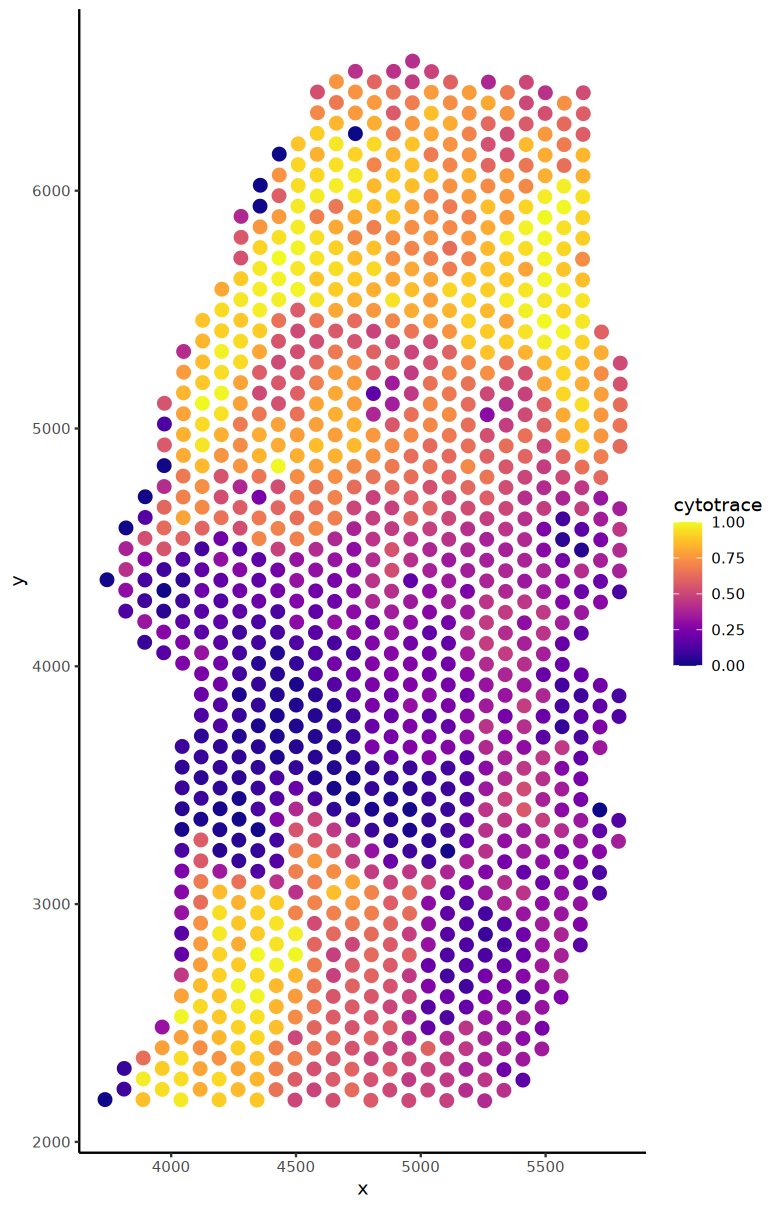

In [61]:
fig_size(fig.height, fig.width)
ct.df <- data.frame(x=coords[, 1], y=coords[, 2], cytotrace=ct.vals, umi=tot.umi)
ct.scatter <- ggplot(data=ct.df, aes(x=x, y=y, color=cytotrace)) + 
    geom_point(size=pt.size) + 
    theme_classic() + 
    scale_color_viridis(option="plasma")
ct.scatter

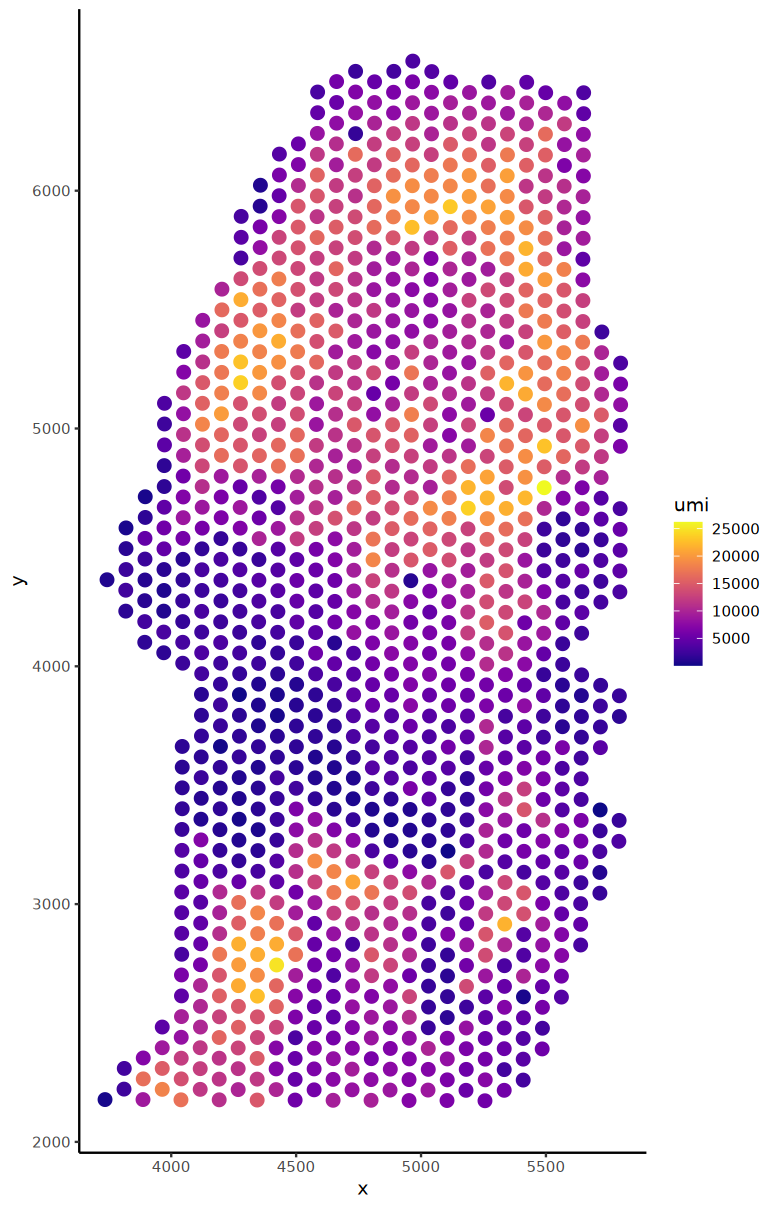

In [62]:
# Total UMI plot
fig_size(fig.height, fig.width)
umi.scatter <- ggplot(data=ct.df, aes(x=x, y=y, color=umi)) + 
    geom_point(size=pt.size) + 
    theme_classic() + 
    scale_color_viridis(option="plasma")
umi.scatter

In [ ]:
for (path.idx in seq(1:length(exp.paths))) {
    exp.path <- exp.paths[path.idx]
    cor.path <- cor.paths[path.idx]
    sample.id <- gsub(".csv", "", basename(exp.path))
    tryCatch({
        message(paste0("Processing: ", sample.id))
        # Cytotrace heavy-lifting; loads or generates and saves.
        ct.results.path <- paste0(int.dir, "/cytotrace/", sample.id, ".rds")
        if (file.exists(ct.results.path)) {
            message("Loading cytotrace")
            ct.results <- readRDS(ct.results.path)
            # Gets umi count
            tot.umi.path <- paste0(int.dir, "/cytotrace/totumi/", sample.id, ".rds")
            if (file.exists(tot.umi.path)) {
                tot.umi <- readRDS(tot.umi.path)
            } else {
                expr <- data.frame(read.table(exp.path, header=TRUE, sep=","))
                gene.names <- expr[, 1]
                # Remove duplicate gene rows and reformat matrix.
                duped.genes <- duplicated(gene.names)
                expr.filt <- expr[!duped.genes, ]
                rownames(expr.filt) <- expr.filt[, 1]
                expr.filt[, 1] <- NULL
                tot.umi <- colSums(expr.filt)
                saveRDS(tot.umi, tot.umi.path)
            }
        } else {
            message("Building cytotrace")
            # Expression values are only used for cytotrace for now.
            expr <- data.frame(read.table(exp.path, header=TRUE, sep=","))
            gene.names <- expr[, 1]
            # Remove duplicate gene rows and reformat matrix.
            duped.genes <- duplicated(gene.names)
            expr.filt <- expr[!duped.genes, ]
            rownames(expr.filt) <- expr.filt[, 1]
            expr.filt[, 1] <- NULL
            colnames(expr.filt) <- gsub("X", "", colnames(expr.filt))
            ct.results <- suppressMessages(suppressWarnings(CytoTRACE(expr.filt, ncores=16, enableFast=FALSE)))
            saveRDS(ct.results, ct.results.path)
        }
        ct.vals <- ct.results$CytoTRACE
        coords <- read.table(cor.path, header=FALSE, sep=",")
        # Calculates total width of figure and relative height.
        x.span <- max(coords[, 1]) - min(coords[, 1])
        y.span <- max(coords[, 2]) - min(coords[, 2])
        span.ratio <-  y.span / x.span
        fig.width <- 6.5
        fig.height <- (fig.width - 1.75) * span.ratio
        # Calculate point size based off of minimum (nonzero) distances between points. 
        coord.dists <- as.matrix(distances(coords))
        min.spot.dist <- min(coord.dists[coord.dists!=0])
        adjust.ptsize <- (min.spot.dist / x.span)
        pt.size <- adjust.ptsize * 75
        # Cytotrace value plot
        ct.df <- data.frame(x=coords[, 1], y=coords[, 2], cytotrace=ct.vals, umi=tot.umi)
        ct.scatter <- ggplot(data=ct.df, aes(x=x, y=y, color=cytotrace)) + 
            geom_point(size=pt.size) + 
            theme_classic() + 
            scale_color_viridis(option="plasma")
        ct.scatter.path <- paste0(ctf.dir, "/cytotrace_scatter_", sample.id, ".png")
        ggsave(filename=ct.scatter.path, plot=ct.scatter, width=fig.width, height=fig.height)
        # Total UMI plot
        umi.scatter <- ggplot(data=ct.df, aes(x=x, y=y, color=umi)) + 
            geom_point(size=pt.size) + 
            theme_classic() + 
            scale_color_viridis(option="plasma")
        umi.scatter.path <- paste0(ctf.dir, "/umi_scatter_", sample.id, ".png")
        ggsave(filename=umi.scatter.path, plot=umi.scatter, width=fig.width, height=fig.height)
        # Correlation between Cytotrace and UMI count
        umi.ct.cor <- cor(ct.vals, tot.umi, method="spearman")
        cor.scatter <- heatscatter(x=tot.umi, y=ct.vals, ggplot=TRUE) + 
            ggtitle(paste0("Spearman Rho: ", round(umi.ct.cor, 3))) + 
            xlab("Total UMI count") + 
            ylab("CytoTRACE score")
        cor.scatter.path <- paste0(ctf.dir, "/cor_scatter_", sample.id, ".png")
        ggsave(filename=cor.scatter.path, plot=cor.scatter, width=7, height=7)
    }, error=function(cond) {
        message(paste("Sample failed:", sample.id))
        message("Original error:")
        message(conditionMessage(cond))
    }, finally={
        message(paste("Sample processed:", sample.id))
    })
}

Processing: p01_fetalliver_slice1_exp

Loading cytotrace

Saving 6.67 x 6.67 in image
Sample processed: p01_fetalliver_slice1_exp

Processing: p01_fetalliver_slice2_exp

Loading cytotrace

Saving 6.67 x 6.67 in image
Sample processed: p01_fetalliver_slice2_exp

Processing: p01_fetalliver_slice3_exp

Loading cytotrace

Saving 6.67 x 6.67 in image
Sample processed: p01_fetalliver_slice3_exp

Processing: p01_fetalspleen_slice1_exp

Loading cytotrace

Saving 6.67 x 6.67 in image
Sample processed: p01_fetalspleen_slice1_exp

Processing: p01_fetalspleen_slice2_exp

Loading cytotrace

Saving 6.67 x 6.67 in image
Sample processed: p01_fetalspleen_slice2_exp

Processing: p01_fetalspleen_slice3_exp

Loading cytotrace

Saving 6.67 x 6.67 in image
Sample processed: p01_fetalspleen_slice3_exp

Processing: p01_fetalspleen_slice4_exp

Loading cytotrace

Saving 6.67 x 6.67 in image
Sample processed: p01_fetalspleen_slice4_exp

Processing: p01_fetalthymus_slice1_exp

Loading cytotrace

Saving 6.67 x 6.